# Predicting Heart Disease Using Machine Learning #
<i> Author: Roshan Lodha </i>
### Section 0: Introduction ###
   
Over the past few decades, the use of data and data itself have exploded in a phenomenon coined "the big-data revoluton." While big-data has trickled into most industries, from finance to fast-food, healthcare has been notoriously slow to adopt it. Paradoxically, the healthcare industry has one of the "cleanest" and most complete datasets in modern history, yet for a plethora of reasons has not been able to capitolize on this. 
    
Through this notebook, I aim to demonstrate just how important data is to modern medicine, and how it is the responsibility of the next few generations to better incroporate advvanced data-science techniques to help bridge healthcare disparity. 

In [1]:
#ignore irrelavant warnings
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Section 1: The Data ###
<i> source: <a href="https://www.kaggle.com/johnsmith88/heart-disease-dataset">David Lapp via Kaggle</a></i>

<b>The dataset:</b> Our dataset is a relatively small one at just over 1000 entries, and contains various measurements for both healthy patients and those with heart complications including markers for age, sex, chest-pain, blood-pressure, resting blood pressure, etc. <br>
<b>Our goal:</b> Using the limited data, we hope to both predict whether or not a certain patient will have heart disease and simultaneously determine which features (measurements) are most indicative of heart complications.

<font color='red'><i>Note: This model should NOT be used as a predictive tool in any capacity for limitations discussed in the conclusion.</i></font>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

heart = pd.read_csv("heart.csv")
heart['bias'] = 1 #add intercept term
heart.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,bias
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,1
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,1
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,1
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,1
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,1


### Section 2: Data Engineering and Feature Selection ###
Taking a look at our data above, we notice a few key details. First, the data is entirely numerical with binary values encoded as 1 or 0; this is important for downstream application. Additionally, we note that there are 14 seemingly orthogonal dimensions (13 + 1 intercept). <br>
In the following section, we will determine which features are important, and measure the true dimensionality of the data both visually and analytically. 

In [3]:
#test-train split
import sklearn.model_selection
train, test = sklearn.model_selection.train_test_split(heart, train_size=0.8, test_size=0.2)
print('Train Shape:', train.shape, '\nTest Shape:', test.shape)

Train Shape: (820, 15) 
Test Shape: (205, 15)


Firstly, we can measure the visualize the covariance between each variable pair using a pairplot. Notably, the second row from the bottom of the pairplot shows how every other variable correlates with heart disease.

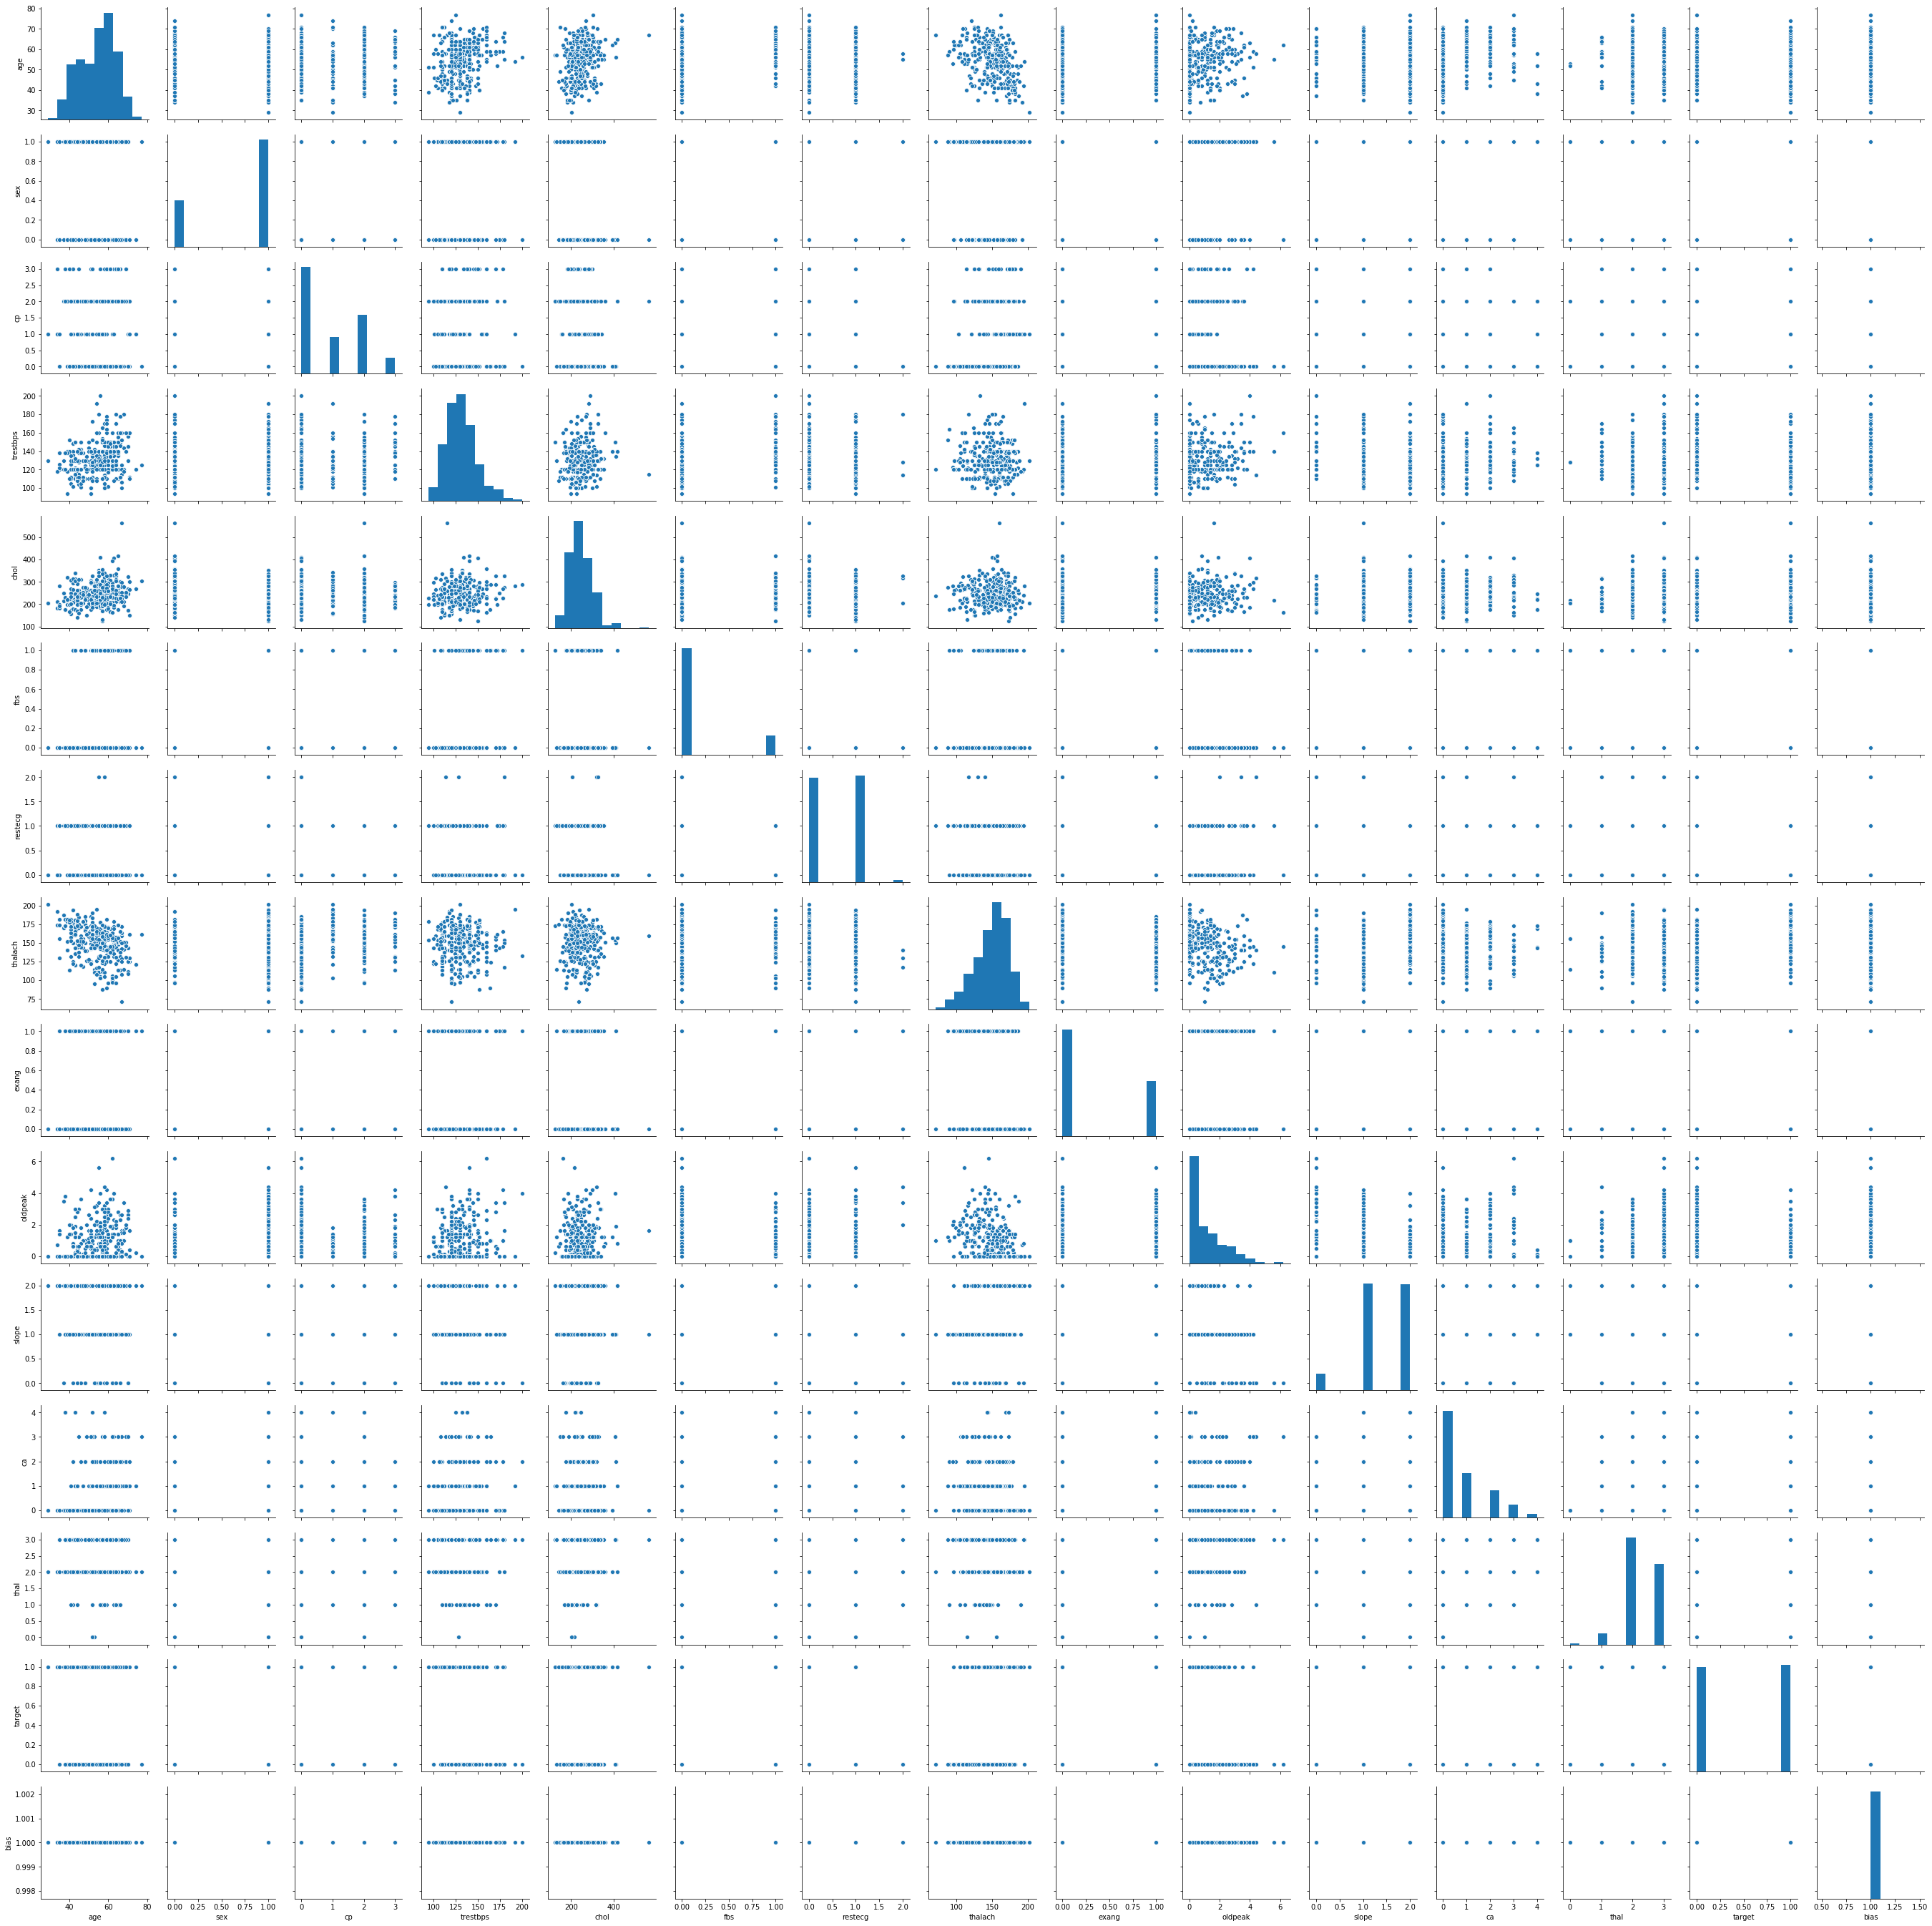

In [4]:
sns.pairplot(train)

In general, we notice very weak correlations between variables, indicating that no single variable is a great predictor. We can take a closer look at a single plot in the pairplot to better explore this.

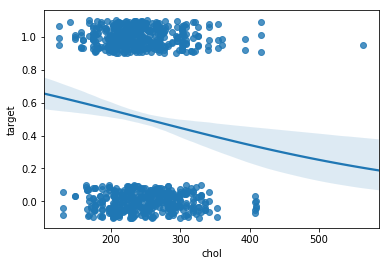

In [5]:
#cholesterol vs heart disease
sns.regplot(x='chol', y='target', data=train, logistic=True, y_jitter=0.1)

The logistic regression line approximated the probability that a patient has heart disease given solely his serum cholesterol level. Obviously the trendline makes no sense, and provides a seemingly opposite relationship than expected.

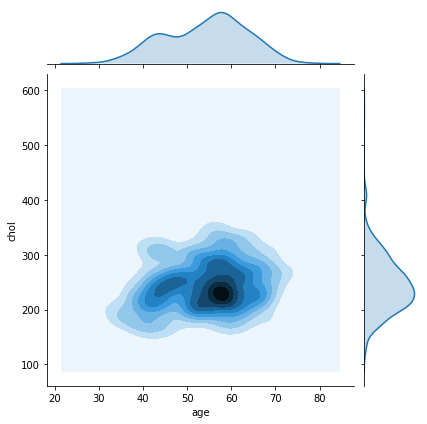

In [6]:
sns.jointplot(x='age', y='chol', data=train, kind='kde')

We can also use a jointplot to show how two non-binary variables covary. Plotted above are cholesteroal and age; we note an extremely tiny positive correlation.

As aforementioned, the weak correlation between nearly all the variables, something which can be proven mathematically using singular value decomposition.

/Users/roshanlodha/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/roshanlodha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


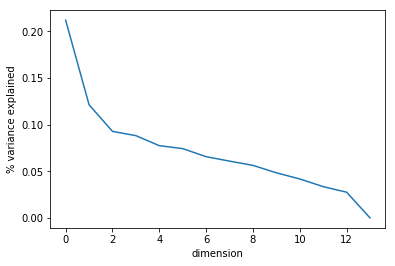

In [7]:
#standardize the data for PCA
from sklearn.preprocessing import StandardScaler

X_pca = np.matrix(StandardScaler().fit_transform(train.drop(['target'], axis=1)))
u, s, vt = np.linalg.svd(X_pca)

var = s**2/np.sum(s**2)
plt.xlabel('dimension')
plt.ylabel('% variance explained')
plt.plot(var)

### Section 3a: Model Selection and Training ###
With all of our exploratory data analysis and data engineering complete, we can train a basic logistic model and assess its accuracy. 

In [8]:
import sklearn.linear_model
lr = sklearn.linear_model.LogisticRegression(fit_intercept=True)

X_train = train.drop(['target'], axis=1)
y_train = train['target']
X_test = test.drop(['target'], axis=1)
y_test = test['target']

lr.fit(X_train, y_train)
train_accuracy = np.sum(lr.predict(X_train) == y_train)/len(X_train)
test_accuracy = np.sum(lr.predict(X_test) == y_test)/len(X_test)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.8598
Test accuracy: 0.8439


### Section 3b: Neural Network ###
Now that we have built a basic classifier, we can see how our accuracy will improve if we use a neural network.
First, we need to convert the dataframe object into raw numeric values, and do another test-train split.

In [9]:
#first, we convert the dataframe into raw numeric values
data = pd.read_csv("heart.csv").values
data.shape

(1025, 14)

We know that the last column of the values is the prediction, so we can now split the data into input (X) and output (Y). From the shape above, we know X will have 13 columns and Y will have 1, both will ahve 1025 rows.

In [10]:
X = data[:, 0:13]
Y = data[:, 13]
X, Y

(array([[52.,  1.,  0., ...,  2.,  2.,  3.],
        [53.,  1.,  0., ...,  0.,  0.,  3.],
        [70.,  1.,  0., ...,  0.,  0.,  3.],
        ...,
        [47.,  1.,  0., ...,  1.,  1.,  2.],
        [50.,  0.,  0., ...,  2.,  0.,  2.],
        [54.,  1.,  0., ...,  1.,  1.,  3.]]),
 array([0., 0., 0., ..., 0., 1., 0.]))

When using a neural network, it is important to normalize the data (subtract the mean), in order to not bias the network. The mathematical basis for this is pretty complex so we can skip over that. 

In [11]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.47916667, 1.        , 0.        , ..., 1.        , 0.5       ,
        1.        ],
       [0.5       , 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.85416667, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.375     , 1.        , 0.        , ..., 0.5       , 0.25      ,
        0.66666667],
       [0.4375    , 0.        , 0.        , ..., 1.        , 0.        ,
        0.66666667],
       [0.52083333, 1.        , 0.        , ..., 0.5       , 0.25      ,
        1.        ]])

For the neural network, beyond the testing and training set, we will use a validation set. This will provide us with a "psuedotest set" for internal validation during network training.

In [12]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)
X_test, X_val, Y_test, Y_val = sklearn.model_selection.train_test_split(X_test, Y_test, test_size=0.5)
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

((820, 13), (103, 13), (102, 13), (820,), (103,), (102,))

Now we can begin building our model. For this model, I have chosen to use the ReLU activation function (activation functions add nonlinearity to increase the range of a network's output), as it is the most efficient. As for architecture, we will build a model with a single hidden layer with ten neurons. In practice, this will be much larger but we have very limited data.

In [13]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential([Dense(25, activation='relu', input_shape=(13,)),
                    Dense(25, activation='relu'),
                    Dense(1, activation='sigmoid'),])

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                 batch_size=5, epochs=10,
                 validation_data=(X_val, Y_val))

model.evaluate(X_test, Y_test)[1]

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 820 samples, validate on 103 samples
Epoch 1/10
820/820 [==============================] - 0s 379us/step - loss: 0.6691 - accuracy: 0.6378 - val_loss: 0.6410 - val_accuracy: 0.7670
Epoch 2/10
820/820 [==============================] - 0s 178us/step - loss: 0.6102 - accuracy: 0.7927 - val_loss: 0.5748 - val_accuracy: 0.7864
Epoch 3/10
820/820 [==============================] - 0s 172us/step - loss: 0.5394 - accuracy: 0.8110 - val_loss: 0.5045 - val_accuracy: 0.8447
Epoch 4/10
820/820 [==============================] - 0s 173us/step - loss: 0.4749 - accuracy: 0.8159 - val_loss: 0.4415 - val_accuracy: 0.8252
Epoch 5/10
820/820 [==============================] - 0s 178us/step - loss: 0.4345 - accuracy: 0.8098 - val_loss: 0.4041 - val_accuracy: 0.8252
Epoch 6/10
820/820 [==============================] - 0s 170us/step - loss: 0.4090 - accuracy: 0.8110 - val_loss: 

0.8039215803146362

A lot of machine learning through neural networks seems like a blackbox. In order to understand better what is going on behind the scenes, we can see how quickly our model is learning.

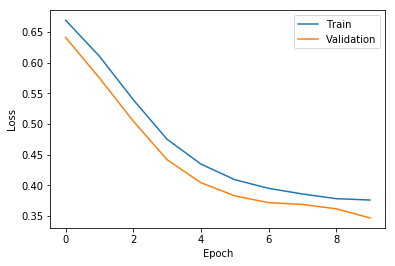

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

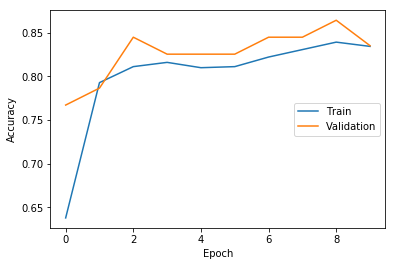

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='right')

### Section 4: Conclusion and Future Avenues###
As week can see, even with such limited data we can achieve a predictive accuracy of nearly 84% on data never seen before. With millions of lines of data, and more dimensions of measurements, the accuracy could easily break 90%. Moreover, our initial model was built without in-depth feature selection, dropout to prevent overfitting, LASSO and RIDGE penalties, and a bunch of other modern techniques which could only improve the quality of the model.

With regards to the neural network, the seemingly low accuracy can be attributeed to a number of factors, including unoptimized batching, poor network architecture, and a low epoch size among others.

The implications of such a simple project, done by someone with limited knowledge in data manipulation techniques are tremendous. Expanding this model to include the aforementioned techniques and training on a larger dataset coupled with robust testing could see similar diagnostic tools be proficient for a hospital setting within the next few years.

With the big-data boom, and data here to stay, it is up to the next few generations of physicians and physician-scientists to help the healthcare industry catch up.